In [243]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy import stats
from statsmodels.graphics.tsaplots import plot_acf
from datetime import timedelta, date, datetime
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.deterministic import Fourier

## 1. 

In [2]:
velec_df = pd.read_csv("data/tsibbledata/vic_elec.csv")
velec_df.Time = pd.to_datetime(velec_df.Time, format="%Y-%m-%dT%H:%M:%SZ")
velec_df.Date = pd.to_datetime(velec_df.Date, format="%Y-%m-%d")

In [3]:
jan14_data = (velec_df.query("Date.dt.year == 2014 and Date.dt.month == 1")
                      .groupby("Date")
                      .agg(total_demand=("Demand", "sum"), 
                           max_temp=("Temperature", "max")
                          ))

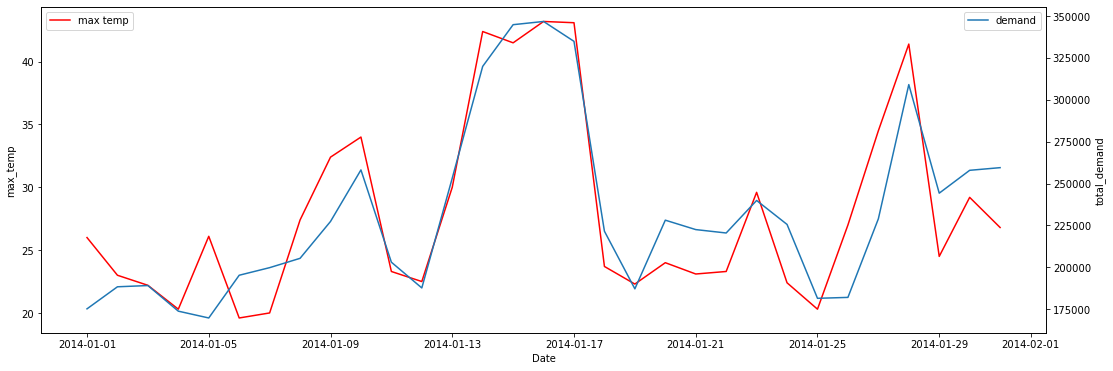

In [4]:
fig, ax = plt.subplots(figsize=(18, 6))
ax2 = ax.twinx()
sns.lineplot(data=jan14_data, y="max_temp", x=jan14_data.index, ax=ax, label="max temp", color="red")
sns.lineplot(data=jan14_data, y="total_demand", x=jan14_data.index, ax=ax2, label="demand")
ax.legend(loc="upper left");

In [5]:
j14_fit = smf.ols('total_demand ~ max_temp', jan14_data).fit()

In [6]:
j14_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           total_demand   R-squared:                       0.783
Model:                            OLS   Adj. R-squared:                  0.776
Method:                 Least Squares   F-statistic:                     104.7
Date:                Wed, 15 Jun 2022   Prob (F-statistic):           3.89e-11
Time:                        19:52:07   Log-Likelihood:                -356.30
No. Observations:                  31   AIC:                             716.6
Df Residuals:                      29   BIC:                             719.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   5.908e+04   1.74e+04      3.391      0.002    2.34e+04    9.47e+04
max_temp    6154.2948    601.322     10.235      0.000    4924.453    7384.137
==============================================================================
Omnibus:                        2.133   Durbin-Watson:                   1.137
Prob(Omnibus):                  0.344   Jarque-Bera (JB):                1.925
Skew:                          -0.531   Prob(JB):                        0.382
Kurtosis:                       2.398   Cond. No.                         115.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

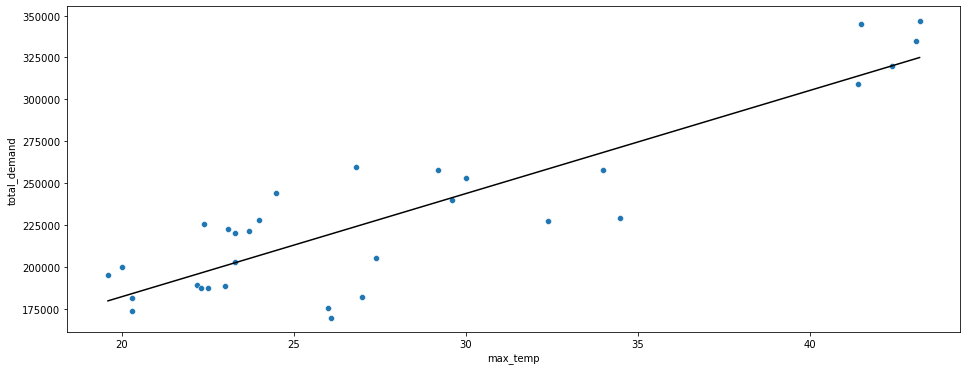

In [7]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.scatterplot(data=jan14_data, x='max_temp', y='total_demand', ax=ax)
sns.lineplot(x=jan14_data.max_temp, y=j14_fit.predict(), color='k');

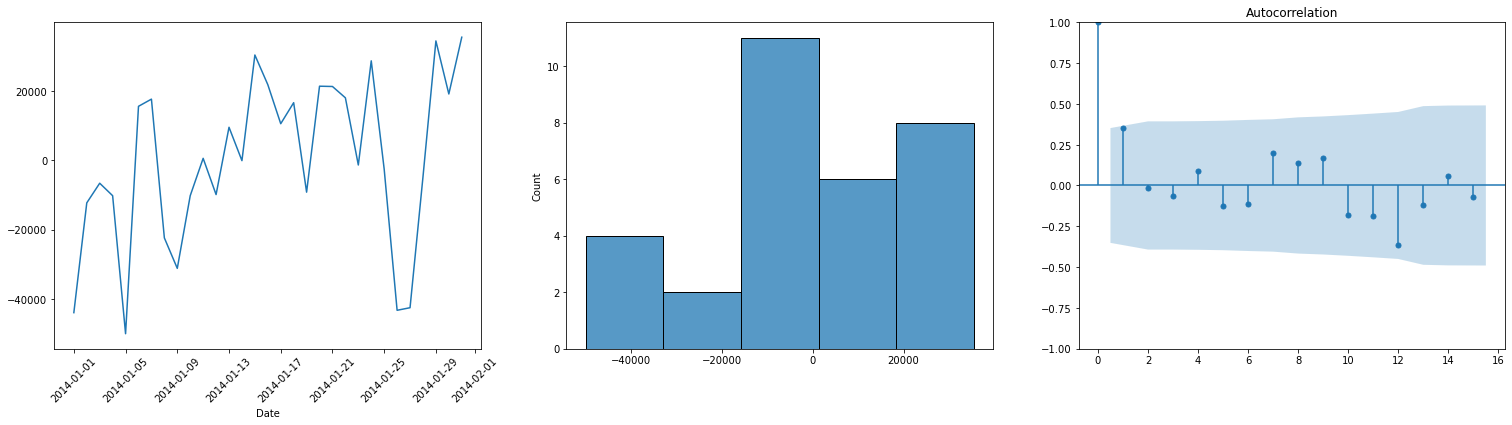

In [8]:
fig, axs = plt.subplots(ncols=3, figsize=(26, 6))
sns.lineplot(x=j14_fit.resid.index, y=j14_fit.resid.values, ax=axs[0])
sns.histplot(x=j14_fit.resid.values, ax=axs[1], bins=5)
plot_acf(j14_fit.resid.values, adjusted=True, ax=axs[2])
axs[0].tick_params(axis='x', rotation=45);

In [9]:
preds = j14_fit.predict(exog=dict(max_temp=[15, 35]))
pred_ci = j14_fit.get_prediction(dict(max_temp=[15, 35])).summary_frame(alpha=.05)

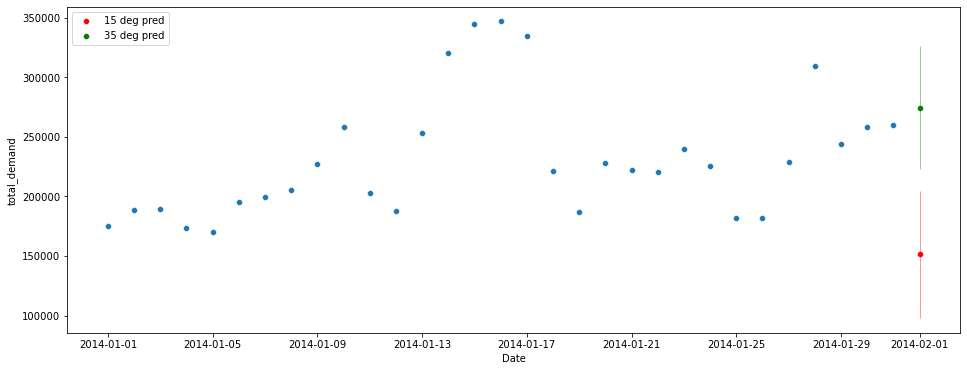

In [10]:
fig, ax = plt.subplots(figsize=(16, 6))

sns.scatterplot(data=jan14_data, x=jan14_data.index, y='total_demand', ax=ax)
sns.scatterplot(x=[jan14_data.index.max() + timedelta(days=1)], y=[preds[0]], label='15 deg pred', color='red', ax=ax)
sns.scatterplot(x=[jan14_data.index.max() + timedelta(days=1)], y=[preds[1]], label='35 deg pred', color='green', ax=ax)
ax.fill_between(x=[jan14_data.index.max() + timedelta(days=1)], y1=[pred_ci.obs_ci_lower.values[0]], y2=[pred_ci.obs_ci_upper.values[0]], alpha=.4, color='red')
ax.fill_between(x=[jan14_data.index.max() + timedelta(days=1)], y1=[pred_ci.obs_ci_lower.values[1]], y2=[pred_ci.obs_ci_upper.values[1]], alpha=.4, color='green')
ax.legend(loc='upper left');

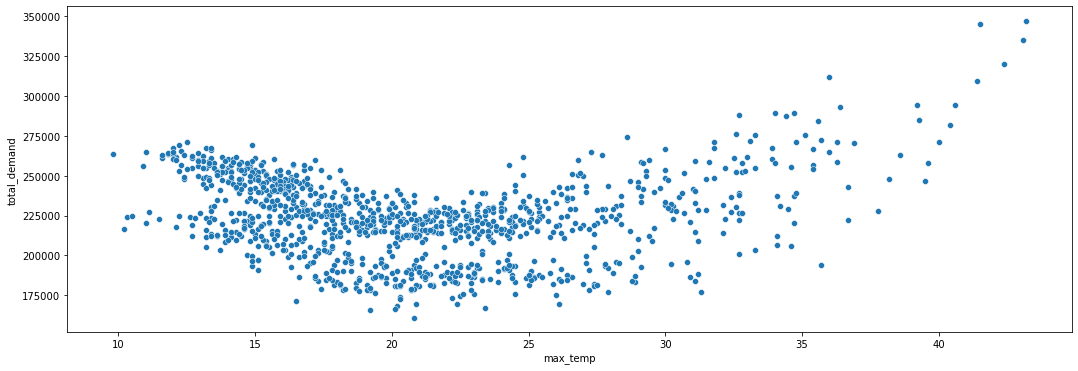

In [11]:
full_data = (velec_df
         .groupby("Date")
         .agg(total_demand=("Demand", "sum"), 
              max_temp=("Temperature", "max")
         )
)

fig, ax = plt.subplots(figsize=(18, 6))
sns.scatterplot(data=full_data, x="max_temp", y="total_demand", ax=ax);

## 2. 

In [13]:
run_df = pd.read_csv("data/tsibbledata/olympic_running.csv")

In [14]:
run_df["Event"] = run_df.Sex + "_" + run_df.Length.astype(str)
run_df.head()


,Year,Length,Sex,Time,Event
0,1896,100,men,12.0,men_100
1,1900,100,men,11.0,men_100
2,1904,100,men,11.0,men_100
3,1908,100,men,10.8,men_100
4,1912,100,men,10.8,men_100


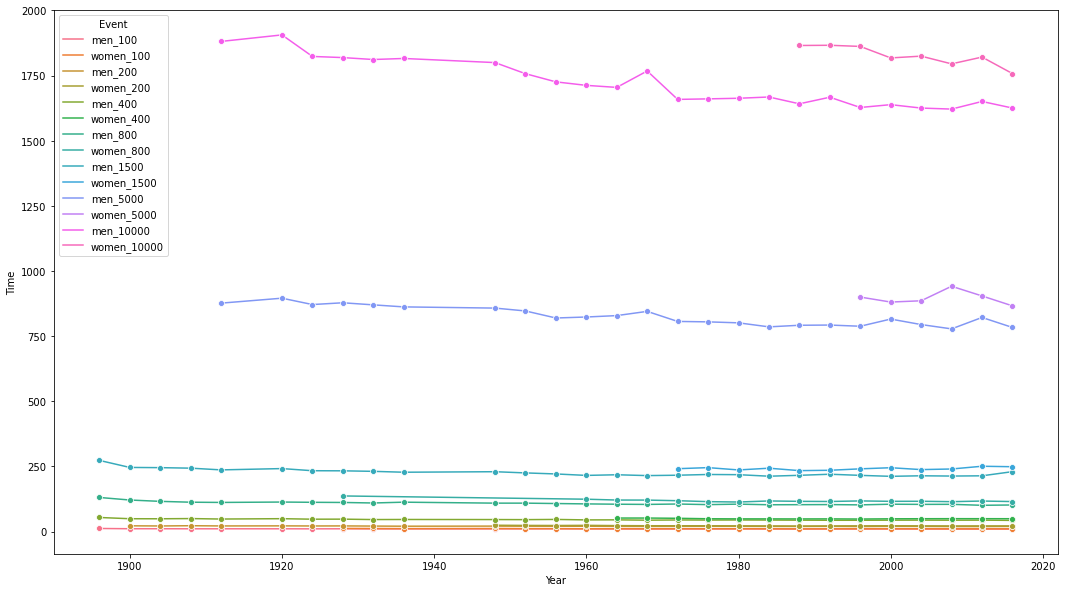

In [15]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.lineplot(data=run_df, x="Year", y="Time", hue="Event", ax=ax, marker="o");

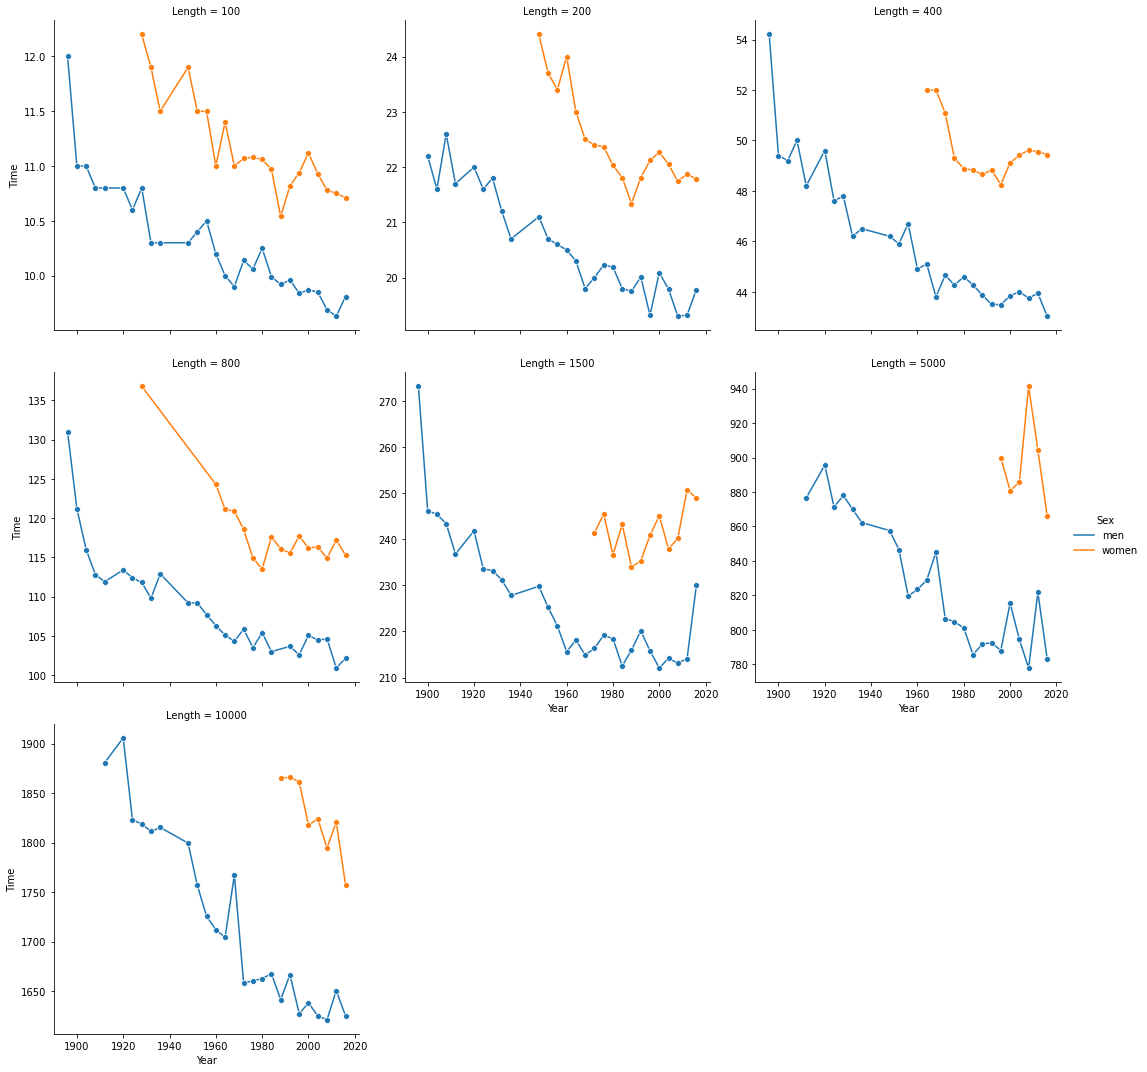

In [16]:
sns.relplot(data=run_df, x="Year", y="Time", hue="Sex", col="Length", col_wrap=3, kind='line', facet_kws={'sharey': False, 'sharex': True}, marker='o');

In [17]:
women100 = run_df.query("Sex == 'women' and Length == 100")
men100 = run_df.query("Sex == 'men' and Length == 100")

In [18]:
w100 = smf.ols('Time ~ Year', women100).fit()
m100 = smf.ols('Time ~ Year', men100).fit()

In [19]:
print(f'women 100 \n{w100.params} \nmen 100 \n{m100.params}')

women 100 
Intercept    39.188164
Year         -0.014185
dtype: float64 
men 100 
Intercept    35.011581
Year         -0.012612
dtype: float64


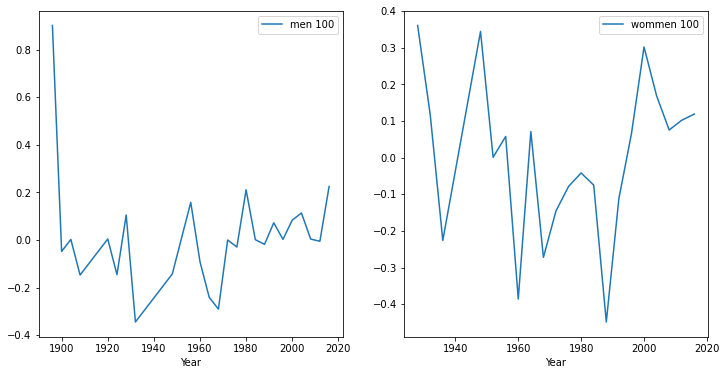

In [20]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 6))

sns.lineplot(x=men100.Year, y=m100.resid, ax=axs[0], label='men 100')
sns.lineplot(x=women100.Year, y=w100.resid, ax=axs[1], label='wommen 100');

## 4. 

In [21]:
souv_df = pd.read_csv("data/fpp3/souvenirs.csv")

In [22]:
souv_df.Month.replace({'Mär':'Mar', 'Mai':'May','Okt':'Oct','Dez':'Dec'}, regex=True, inplace=True)
souv_df.Month = pd.to_datetime(souv_df.Month, format="%Y %b")

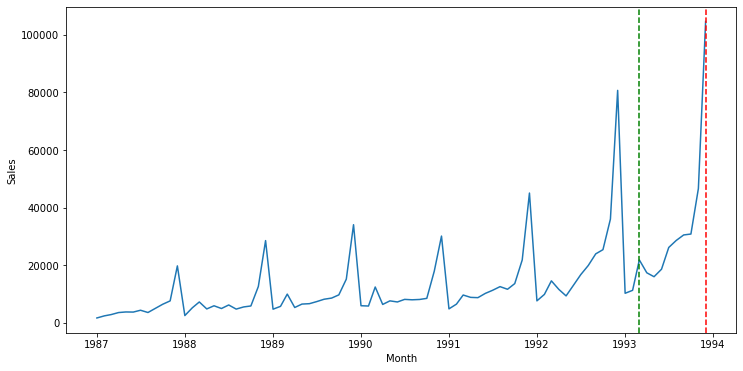

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=souv_df, x="Month", y="Sales", ax=ax)
ax.axvline(datetime(1993, 12, 1), 0, 110000, color='red', linestyle='--')
ax.axvline(datetime(1993, 3, 1), 0, 110000, color='green', linestyle='--');

In [24]:
souv_df["Festival"] = (souv_df.Month.dt.month == 3) & (souv_df.Month.dt.year >= 1988)
souv_df["Q"] = souv_df.Month.dt.quarter
souv_df["M"] = souv_df.Month.dt.month
souv_df["Y"] = souv_df.Month.dt.year
souv_df["tindex"] = np.arange(souv_df.shape[0])
souv_df.head(2)

,Month,Sales,Festival,Q,M,Y,tindex
0,1987-01-01,1664.81,False,1,1,1987,0
1,1987-02-01,2397.53,False,1,2,1987,1


In [94]:
yrs = souv_df.Y.unique().tolist() 
yrs.extend([1994, 1995, 1996])

In [200]:
v = souv_df[["Y", "M"]].values

In [213]:
souv_lr = smf.ols('np.log(Sales) ~ tindex + Festival +  C(M)', souv_df).fit()

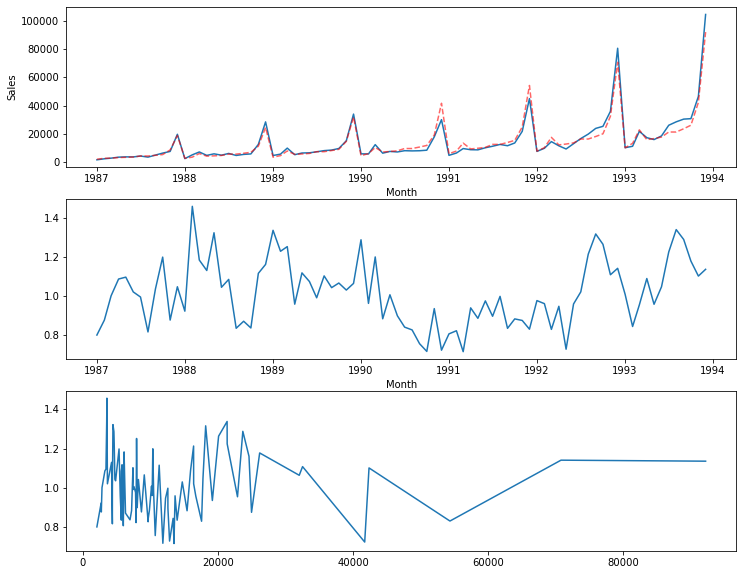

In [215]:
fig, axs = plt.subplots(figsize=(12, 10), nrows=3)
sns.lineplot(data=souv_df, x="Month", y="Sales", ax=axs[0])
sns.lineplot(x=souv_df.Month, y=np.exp(souv_lr.predict()), ax=axs[0], linestyle='--', alpha=.6, color='red')

sns.lineplot(x=souv_df.Month, y=np.exp(souv_lr.resid), ax=axs[1])
sns.lineplot(x=np.exp(souv_lr.predict()), y=np.exp(souv_lr.resid), ax=axs[2]);

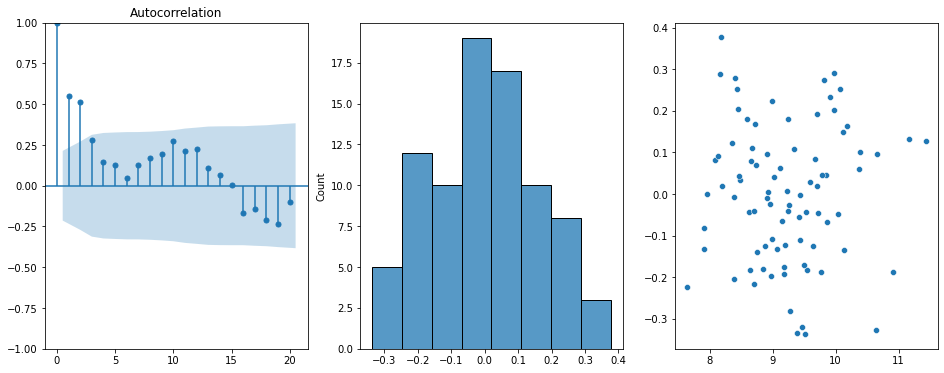

In [216]:
fig, axs = plt.subplots(ncols=3, figsize=(16, 6))

plot_acf(souv_lr.resid.values, adjusted=True, ax=axs[0])
sns.histplot(souv_lr.resid, ax=axs[1])
sns.scatterplot(x=souv_lr.predict(), y=souv_lr.resid, ax=axs[2]);

In [217]:
souv_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          np.log(Sales)   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.949
Method:                 Least Squares   F-statistic:                     119.0
Date:                Thu, 16 Jun 2022   Prob (F-statistic):           2.58e-42
Time:                        13:43:26   Log-Likelihood:                 32.981
No. Observations:                  84   AIC:                            -37.96
Df Residuals:                      70   BIC:                            -3.931
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            7.6417      0.074    103.391      0.000       7.494       7.789
Festival[T.True]     0.5015      0.196      2.553      0.013       0.110       0.893
C(M)[T.2]            0.2514      0.096      2.628      0.011       0.061       0.442
C(M)[T.3]            0.2661      0.193      1.376      0.173      -0.120       0.652
C(M)[T.4]            0.3841      0.096      4.013      0.000       0.193       0.575
C(M)[T.5]            0.4095      0.096      4.277      0.000       0.219       0.600
C(M)[T.6]            0.4488      0.096      4.687      0.000       0.258       0.640
C(M)[T.7]            0.6105      0.096      6.372      0.000       0.419       0.802
C(M)[T.8]            0.5880      0.096      6.134      0.000       0.397       0.779
C(M)[T.9]            0.6693      0.096      6.979      0.000       0.478       0.861
C(M)[T.10]           0.7474      0.096      7.788      0.000       0.556       0.939
C(M)[T.11]           1.2067      0.096     12.566      0.000       1.015       1.398
C(M)[T.12]           1.9622      0.096     20.417      0.000       1.771       2.154
tindex               0.0220      0.001     26.634      0.000       0.020       0.024
==============================================================================
Omnibus:                        1.807   Durbin-Watson:                   0.889
Prob(Omnibus):                  0.405   Jarque-Bera (JB):                1.315
Skew:                          -0.019   Prob(JB):                        0.518
Kurtosis:                       2.388   Cond. No.                         680.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [218]:
acorr_ljungbox(souv_lr.resid, model_df=18, lags=[28])

,lb_stat,lb_pvalue
28,139.448625,5.466509e-25


In [219]:
pred_data = souv_df.loc[souv_df.Month.dt.year >= 1991]
for yr in [1991, 1992, 1993]:
    pred_data.loc[pred_data.Month.dt.year == yr, "Y"] = yr + 3
pred_data.head(2)

,Month,Sales,Festival,Q,M,Y,tindex
48,1991-01-01,4826.64,False,1,1,1994,48
49,1991-02-01,6470.23,False,1,2,1994,49


In [220]:
pred_data.loc[:,'tindex'] = np.arange(84, 84+len(pred_data))

/tmp/ipykernel_22688/1131883070.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pred_data.loc[:,'tindex'] = np.arange(84, 84+len(pred_data))


In [221]:
pred_data = pred_data.drop(columns=["Month", "Sales", "Y"])

In [223]:
souv_preds = souv_lr.get_prediction(pred_data)

In [224]:
sm_frame = souv_preds.summary_frame()
sm_frame.head()

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,9.491352,0.078433,9.334923,9.647782,9.101594,9.881110
1,9.764789,0.078433,9.608359,9.921219,9.375031,10.154547
2,10.302990,0.080904,10.141632,10.464348,9.911228,10.694752
3,9.941465,0.078433,9.785036,10.097895,9.551707,10.331223
4,9.988919,0.078433,9.832489,10.145348,9.599161,10.378677


In [225]:
sm_frame_t = np.exp(sm_frame)

In [226]:
pred_dates = pd.date_range(start='1994-01-01', end='1996-12-01', freq='MS')

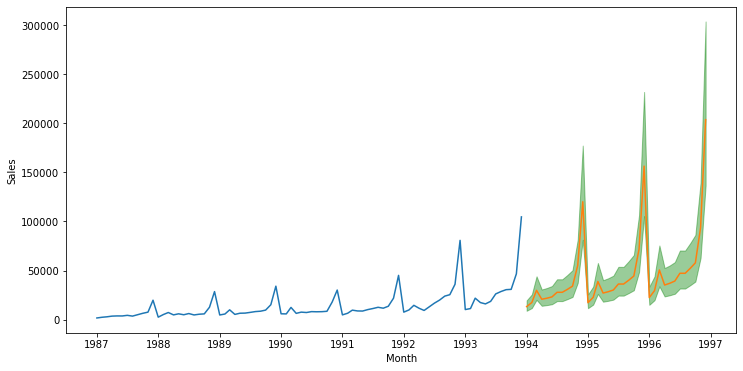

In [228]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(data=souv_df, x="Month", y="Sales", ax=ax)
sns.lineplot(x=pred_dates, y=sm_frame_t["mean"], ax=ax)
ax.fill_between(x=pred_dates, y1=sm_frame_t.obs_ci_lower, y2=sm_frame_t.obs_ci_upper, alpha=.4, color='green');

## 5. 

In [330]:
gas_df = pd.read_csv("data/fpp3/us_gasoline.csv")
gas_df.Week = pd.to_datetime(gas_df.Week + '0', format="%Y W%U%w")

In [331]:
gas04 = gas_df.loc[gas_df.Week.dt.year <= 2004]

In [332]:
gas04.head(1)

,Week,Barrels
0,1991-02-10,6.621


In [414]:
fr = Fourier(52, 6)
data_fr = fr.in_sample(gas04.index)
data_fr.head(12)

,"sin(1,52)","cos(1,52)","sin(2,52)","cos(2,52)","sin(3,52)","cos(3,52)","sin(4,52)","cos(4,52)","sin(5,52)","cos(5,52)","sin(6,52)","cos(6,52)"
0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,0.120537,0.992709,0.239316,0.970942,0.354605,0.935016,0.464723,0.885456,0.568065,0.822984,0.663123,0.748511
2,0.239316,0.970942,0.464723,0.885456,0.663123,0.748511,0.822984,0.568065,0.935016,0.354605,0.992709,0.120537
3,0.354605,0.935016,0.663123,0.748511,0.885456,0.464723,0.992709,0.120537,0.970942,-0.239316,0.822984,-0.568065
4,0.464723,0.885456,0.822984,0.568065,0.992709,0.120537,0.935016,-0.354605,0.663123,-0.748511,0.239316,-0.970942
5,0.568065,0.822984,0.935016,0.354605,0.970942,-0.239316,0.663123,-0.748511,0.120537,-0.992709,-0.464723,-0.885456
6,0.663123,0.748511,0.992709,0.120537,0.822984,-0.568065,0.239316,-0.970942,-0.464723,-0.885456,-0.935016,-0.354605
7,0.748511,0.663123,0.992709,-0.120537,0.568065,-0.822984,-0.239316,-0.970942,-0.885456,-0.464723,-0.935016,0.354605
8,0.822984,0.568065,0.935016,-0.354605,0.239316,-0.970942,-0.663123,-0.748511,-0.992709,0.120537,-0.464723,0.885456
9,0.885456,0.464723,0.822984,-0.568065,-0.120537,-0.992709,-0.935016,-0.354605,-0.748511,0.663123,0.239316,0.970942


In [416]:
gas04_fr = pd.concat([gas04, data_fr], axis=1)

In [417]:
gas04_fr.columns = ["Week", "Barrels", "Sin1", "Cos1", "Sin2", "Cos2", "Sin3", "Cos3", "Sin4", "Cos4", "Sin5", "Cos5", "Sin6", "Cos6"]
gas04_fr.head()

,Week,Barrels,Sin1,Cos1,Sin2,Cos2,Sin3,Cos3,Sin4,Cos4,Sin5,Cos5,Sin6,Cos6
0,1991-02-10,6.621,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
1,1991-02-17,6.433,0.120537,0.992709,0.239316,0.970942,0.354605,0.935016,0.464723,0.885456,0.568065,0.822984,0.663123,0.748511
2,1991-02-24,6.582,0.239316,0.970942,0.464723,0.885456,0.663123,0.748511,0.822984,0.568065,0.935016,0.354605,0.992709,0.120537
3,1991-03-03,7.224,0.354605,0.935016,0.663123,0.748511,0.885456,0.464723,0.992709,0.120537,0.970942,-0.239316,0.822984,-0.568065
4,1991-03-10,6.875,0.464723,0.885456,0.822984,0.568065,0.992709,0.120537,0.935016,-0.354605,0.663123,-0.748511,0.239316,-0.970942


In [418]:
g4_fr_lr = smf.ols('Barrels ~ index + Sin1 + Cos1 + Sin2 + Cos2 + Sin3 + Cos3 + Sin4 + Cos4 + Sin5 + Cos5 + Sin6 + Cos6', gas04_fr.reset_index()).fit()

In [419]:
g4_fr_lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                Barrels   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     301.2
Date:                Thu, 16 Jun 2022   Prob (F-statistic):          1.06e-278
Time:                        16:39:24   Log-Likelihood:                -71.919
No. Observations:                 725   AIC:                             171.8
Df Residuals:                     711   BIC:                             236.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.0990      0.020    354.010      0.000       7.060       7.138
index          0.0028    4.8e-05     58.199      0.000       0.003       0.003
Sin1          -0.0007      0.014     -0.050      0.960      -0.029       0.027
Cos1          -0.2709      0.014    -19.079      0.000      -0.299      -0.243
Sin2          -0.0418      0.014     -2.950      0.003      -0.070      -0.014
Cos2          -0.0190      0.014     -1.337      0.182      -0.047       0.009
Sin3           0.0126      0.014      0.890      0.374      -0.015       0.040
Cos3          -0.0961      0.014     -6.781      0.000      -0.124      -0.068
Sin4           0.0180      0.014      1.272      0.204      -0.010       0.046
Cos4          -0.0373      0.014     -2.635      0.009      -0.065      -0.010
Sin5          -0.0029      0.014     -0.208      0.836      -0.031       0.025
Cos5          -0.0456      0.014     -3.222      0.001      -0.073      -0.018
Sin6           0.0439      0.014      3.096      0.002       0.016       0.072
Cos6          -0.0563      0.014     -3.976      0.000      -0.084      -0.028
==============================================================================
Omnibus:                        2.191   Durbin-Watson:                   2.157
Prob(Omnibus):                  0.334   Jarque-Bera (JB):                2.123
Skew:                          -0.065   Prob(JB):                        0.346
Kurtosis:                       3.231   Cond. No.                         838.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

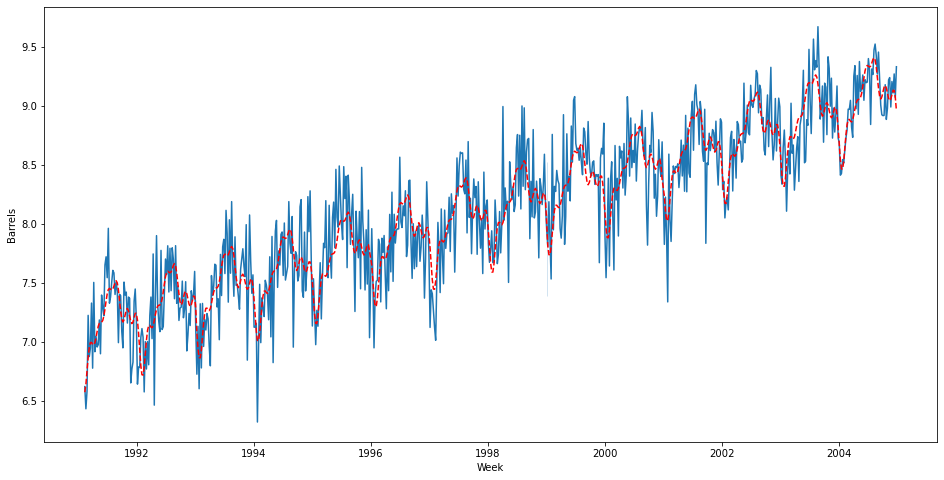

In [420]:
fig, ax = plt.subplots(figsize=(16, 8))

sns.lineplot(data=gas04_fr, x="Week", y="Barrels", ax=ax)
sns.lineplot(x=gas04_fr.Week, y=g4_fr_lr.predict(), ax=ax, color='r', linestyle='--');

## 6. 

In [423]:
ec_df = pd.read_csv("data/tsibbledata/global_economy.csv")
ec_df = ec_df.loc[ec_df.Country == "Afghanistan"]
ec_df.head(2)

,Country,Code,Year,GDP,Growth,CPI,Imports,Exports,Population
0,Afghanistan,AFG,1960,5.377778e+08,NaN,NaN,7.024793,4.132233,8996351.0
1,Afghanistan,AFG,1961,5.488889e+08,NaN,NaN,8.097166,4.453443,9166764.0


In [429]:
ec_df["k1"] = ec_df.Year.apply(lambda x: 0 if x < 1980 else x - 1980)
ec_df["k2"] = ec_df.Year.apply(lambda x: 0 if x < 1989 else x - 1989)

In [430]:
ec_lr = smf.ols('Population ~ Year + k1 + k2', ec_df).fit()

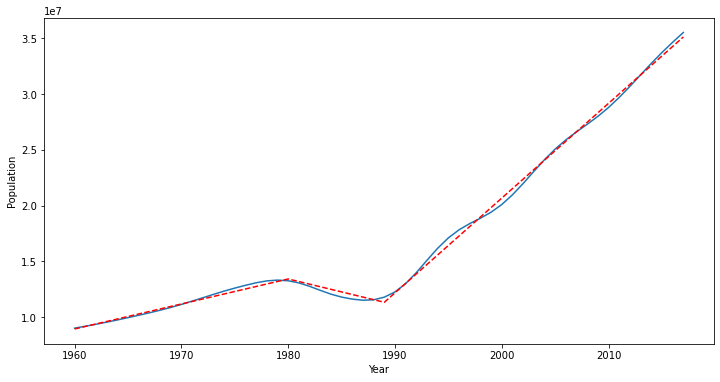

In [431]:
fig, ax = plt.subplots(figsize=(12, 6))

sns.lineplot(data=ec_df, x="Year", y="Population", ax=ax)
sns.lineplot(x=ec_df.Year, y=ec_lr.fittedvalues, ax=ax, linestyle='--', color='red');

## Beer Production Example

In [395]:
beer = pd.read_csv("data/tsibbledata/aus_production.csv")
beer["Quarter"] = pd.DatetimeIndex(beer.Quarter.replace({" ": "-"}, regex=True), freq="QS")
beer = beer.loc[beer.Quarter.dt.year >= 1992]
beer.reset_index(inplace=True, drop=True)
beer.drop(columns=["Tobacco", "Bricks", "Cement", "Gas", "Electricity"], inplace=True)

In [407]:
fr = Fourier(4, 2)
beer_fr = fr.in_sample(beer.index)
beer_fr.head(1)

,"sin(1,4)","cos(1,4)","sin(2,4)","cos(2,4)"
0,0.0,1.0,0.0,1.0


In [397]:
beer = pd.concat([beer, beer_fr], axis=1)
beer = beer.reset_index()

In [400]:
beer.columns = ["index", "Quarter", "Beer", "Sin1", "Cos1", "Sin2", "Cos2"]
beer.head()

,index,Quarter,Beer,Sin1,Cos1,Sin2,Cos2
0,0,1992-01-01,443,0.000000e+00,1.000000e+00,0.000000e+00,1.0
1,1,1992-04-01,410,1.000000e+00,6.123234e-17,1.224647e-16,-1.0
2,2,1992-07-01,420,1.224647e-16,-1.000000e+00,-2.449294e-16,1.0
3,3,1992-10-01,532,-1.000000e+00,-1.836970e-16,3.673940e-16,-1.0
4,4,1993-01-01,433,-2.449294e-16,1.000000e+00,-4.898587e-16,1.0


In [403]:
mdl = smf.ols('Beer ~ index + Sin1 + Cos1 + Sin2 + Cos2', beer).fit()

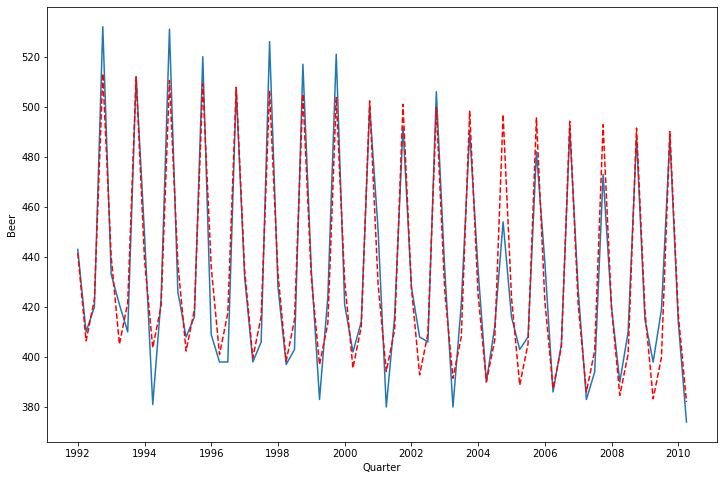

In [406]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.lineplot(data=beer, x="Quarter", y="Beer", ax=ax)
sns.lineplot(x=beer.Quarter, y=mdl.fittedvalues, ax=ax, color='red', linestyle='--');